In [1]:
import pyspark
from pyspark import SparkContext
from pyspark.sql import SparkSession
from pyspark.sql import SQLContext
from pyspark.sql.functions import col, explode, to_timestamp, udf, window, to_date, hour, date_format
from pyspark.sql.functions import desc, max, avg ,count
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from pyspark.sql.types import DoubleType,IntegerType
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml import Pipeline


In [2]:
conf= pyspark.SparkConf().set("spark.jars.packages",\
                              "org.mongodb.spark:mongo-spark-connector_2.12:3.0.1").\
                              setMaster("local").setAppName("mongoJSON").\
                              setAll([("spark.driver.memory","40g"), ("spark.executor.memory","50g")])\
                              

In [3]:
# Create a SparkSession
spark = SparkSession.\
builder.config(conf=conf).\
getOrCreate()

In [4]:
mongo_ip="mongodb://localhost:27017/sensebox."

In [5]:
df=spark.read.format("com.mongodb.spark.sql.DefaultSource").option("uri", mongo_ip + "data").load()

In [6]:
df.na.drop(how = "any")

DataFrame[_id: string, createdAt: string, currentLocation: struct<coordinates:array<double>,timestamp:string,type:string>, description: string, exposure: string, grouptag: array<string>, image: string, lastMeasurementAt: string, model: string, name: string, sensors: array<struct<__v:int,_id:string,boxes_id:string,icon:string,lastMeasurement:string,sensorType:string,title:string,unit:string>>, updatedAt: string, weblink: string]

In [7]:
df.show()

+--------------------+--------------------+--------------------+--------------------+--------+-----------+-----+--------------------+------+--------------------+--------------------+--------------------+-------+
|                 _id|           createdAt|     currentLocation|         description|exposure|   grouptag|image|   lastMeasurementAt| model|                name|             sensors|           updatedAt|weblink|
+--------------------+--------------------+--------------------+--------------------+--------+-----------+-----+--------------------+------+--------------------+--------------------+--------------------+-------+
|5386026e5f0882200...|2022-03-30T11:25:...|{[10.599517878144...|                NULL| unknown|         []| NULL|                NULL|custom|            CALIMERO|[{0, 5386026e5f08...|2022-03-30T11:25:...|   NULL|
|538ee6a4a83415541...|2022-03-30T11:25:...|{[9.2060887812476...|                NULL| unknown|         []| NULL|                NULL|custom|SenGIS Arbei

In [8]:
df.printSchema()

root
 |-- _id: string (nullable = true)
 |-- createdAt: string (nullable = true)
 |-- currentLocation: struct (nullable = true)
 |    |-- coordinates: array (nullable = true)
 |    |    |-- element: double (containsNull = true)
 |    |-- timestamp: string (nullable = true)
 |    |-- type: string (nullable = true)
 |-- description: string (nullable = true)
 |-- exposure: string (nullable = true)
 |-- grouptag: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- image: string (nullable = true)
 |-- lastMeasurementAt: string (nullable = true)
 |-- model: string (nullable = true)
 |-- name: string (nullable = true)
 |-- sensors: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- __v: integer (nullable = true)
 |    |    |-- _id: string (nullable = true)
 |    |    |-- boxes_id: string (nullable = true)
 |    |    |-- icon: string (nullable = true)
 |    |    |-- lastMeasurement: string (nullable = true)
 |    |    |-- sensorType:

In [9]:
df = df.withColumn("createdAt", to_timestamp(col("createdAt"))) \
       .withColumn("updatedAt", to_timestamp(col("updatedAt")))


In [10]:
df.show(1)

+--------------------+--------------------+--------------------+-----------+--------+--------+-----+-----------------+------+--------+--------------------+--------------------+-------+
|                 _id|           createdAt|     currentLocation|description|exposure|grouptag|image|lastMeasurementAt| model|    name|             sensors|           updatedAt|weblink|
+--------------------+--------------------+--------------------+-----------+--------+--------+-----+-----------------+------+--------+--------------------+--------------------+-------+
|5386026e5f0882200...|2022-03-30 16:25:...|{[10.599517878144...|       NULL| unknown|      []| NULL|             NULL|custom|CALIMERO|[{0, 5386026e5f08...|2022-03-30 16:25:...|   NULL|
+--------------------+--------------------+--------------------+-----------+--------+--------+-----+-----------------+------+--------+--------------------+--------------------+-------+
only showing top 1 row



In [11]:
sensors_df = df.withColumn("sensor", explode(col("sensors"))) \
               .select(
                   col("_id").alias("box_id"),
                   col("name"),
                   col("createdAt"),
                   col("updatedAt"),
                   col("currentLocation.coordinates").alias("coordinates"),
                   col("sensor._id").alias("sensor_id"),
                   col("sensor.lastMeasurement"),
                   col("sensor.sensorType"),
                   col("sensor.title"),
                   col("sensor.unit")
               )

In [12]:
sensors_df.show(1)

+--------------------+--------+--------------------+--------------------+--------------------+--------------------+--------------------+----------+----------+-----+
|              box_id|    name|           createdAt|           updatedAt|         coordinates|           sensor_id|     lastMeasurement|sensorType|     title| unit|
+--------------------+--------+--------------------+--------------------+--------------------+--------------------+--------------------+----------+----------+-----+
|5386026e5f0882200...|CALIMERO|2022-03-30 16:25:...|2022-03-30 16:25:...|[10.5995178781449...|5386026e5f0882200...|5c5c00e7358095001...|    GL5528|Helligkeit|Pegel|
+--------------------+--------+--------------------+--------------------+--------------------+--------------------+--------------------+----------+----------+-----+
only showing top 1 row



In [13]:
temporal_df = sensors_df.groupBy("createdAt").count().orderBy("createdAt")


In [14]:
temporal_pd = temporal_df.toPandas()

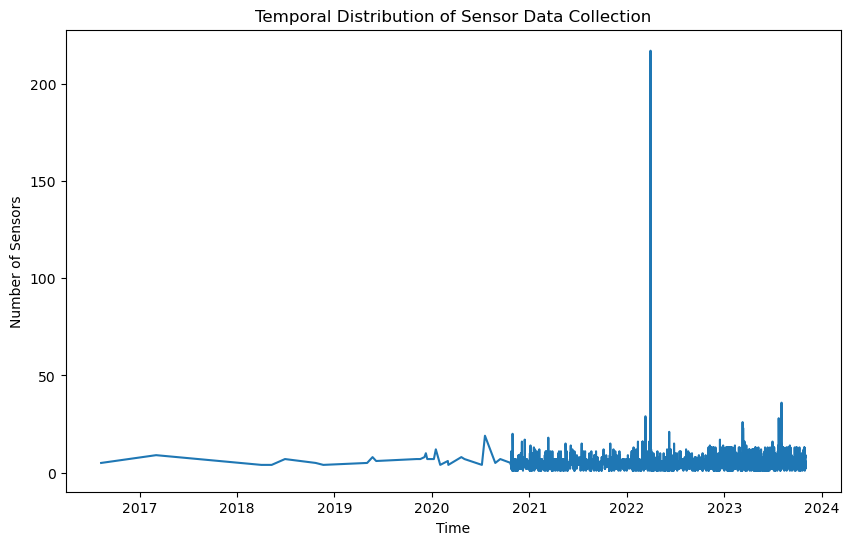

In [15]:
plt.figure(figsize=(10, 6))
sns.lineplot(data=temporal_pd, x="createdAt", y="count")
plt.title('Temporal Distribution of Sensor Data Collection')
plt.xlabel('Time')
plt.ylabel('Number of Sensors')
plt.show()


In [16]:
sensor_type_df = sensors_df.groupBy("sensorType").count().orderBy("count", ascending=False)


In [17]:
sensor_type_df.show()

+-------------+-----+
|   sensorType|count|
+-------------+-----+
|      SDS 011|15972|
|       BME280|11925|
|        DHT22| 5304|
|      HDC1080| 4741|
|       BME680| 3025|
|       BMP280| 2424|
|     VEML6070| 1921|
|     TSL45315| 1834|
|      HDC1008| 1025|
|        SCD30|  891|
| Colorimetrie|  868|
|        SPS30|  822|
|        SMT50|  772|
|       SDS011|  692|
|          AAS|  651|
|        DHT11|  335|
|       BMP180|  317|
|Wetterstation|  311|
|       kupfer|  238|
|     PMS 7003|  219|
+-------------+-----+
only showing top 20 rows



In [18]:
sensor_type_df_best = sensors_df.groupBy("sensorType").count().orderBy("count", ascending=False)

In [19]:
sensor_type_df_best = sensor_type_df_best.limit(10)

In [20]:
sensor_type_df_best_pd = sensor_type_df_best.toPandas()

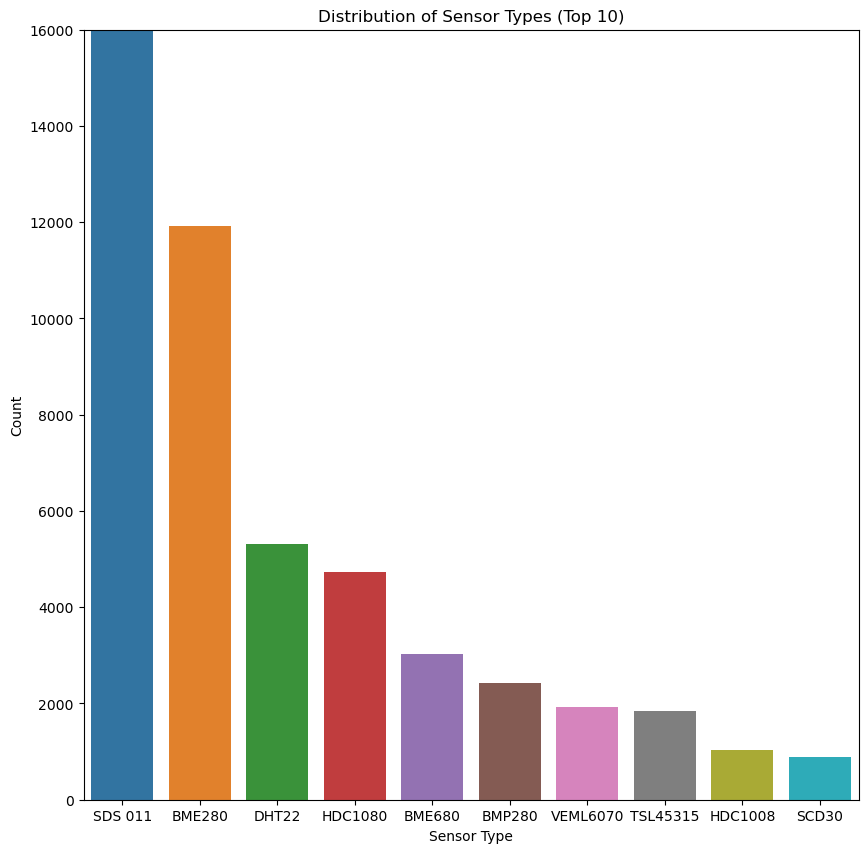

In [21]:

plt.figure(figsize=(10, 10))
sns.barplot(data=sensor_type_df_best_pd, x="sensorType", y="count")
plt.title('Distribution of Sensor Types (Top 10)')
plt.xlabel('Sensor Type')
plt.ylabel('Count')
plt.ylim(0,16000)
plt.show()

In [22]:
sensor_usage_per_year = sensors_df.groupBy("createdAt", "sensorType") \
                                  .agg(count("*").alias("usage_count")) \
                                  .orderBy("createdAt", desc("usage_count"))



In [23]:
sensor_usage_per_year.show()

+--------------------+----------+-----------+
|           createdAt|sensorType|usage_count|
+--------------------+----------+-----------+
|2016-08-10 00:34:...|   HDC1008|          2|
|2016-08-10 00:34:...|  TSL45315|          1|
|2016-08-10 00:34:...|  VEML6070|          1|
|2016-08-10 00:34:...|    BMP280|          1|
|2017-03-03 23:20:...|    BME280|          3|
|2017-03-03 23:20:...|    SDS011|          2|
|2017-03-03 23:20:...|       DHT|          2|
|2017-03-03 23:20:...|      WiFi|          1|
|2017-03-03 23:20:...| Raspberry|          1|
|2017-08-09 20:51:...|    BME280|          3|
|2017-08-09 20:51:...|   SDS 011|          2|
|2017-08-09 20:51:...|     DHT22|          2|
|2018-04-02 03:11:...|   SDS 011|          2|
|2018-04-02 03:11:...|     DHT22|          2|
|2018-05-11 01:14:...|     DHT22|          2|
|2018-05-11 01:14:...|   SDS 011|          2|
|2018-06-29 22:26:...|   HDC1080|          2|
|2018-06-29 22:26:...|   SDS 011|          2|
|2018-06-29 22:26:...|  VEML6070| 

In [24]:
sensor_usage_per_year_2 = sensors_df.groupBy("sensorType").count().orderBy("count", ascending=False)

In [25]:
sensor_usage_per_year_2.show()

+-------------+-----+
|   sensorType|count|
+-------------+-----+
|      SDS 011|15972|
|       BME280|11925|
|        DHT22| 5304|
|      HDC1080| 4741|
|       BME680| 3025|
|       BMP280| 2424|
|     VEML6070| 1921|
|     TSL45315| 1834|
|      HDC1008| 1025|
|        SCD30|  891|
| Colorimetrie|  868|
|        SPS30|  822|
|        SMT50|  772|
|       SDS011|  692|
|          AAS|  651|
|        DHT11|  335|
|       BMP180|  317|
|Wetterstation|  311|
|       kupfer|  238|
|     PMS 7003|  219|
+-------------+-----+
only showing top 20 rows

